In [15]:
# imporing packages
import seaborn
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip

from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


i used `RTX3070` as GPU device

# Loading CIFAR-10 

In [17]:
tensorShape = [112,112]
transforms = Compose([
                    ToTensor(),
                    Resize((tensorShape[0],tensorShape[1])),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
training_data_cifar10 = CIFAR10(
    root="CIFAR-10", 
    train=True, 
    download=True, 
    transform=transforms
)

test_data_cifar10 = CIFAR10(
    root="CIFAR-10",
    train=False,
    download=True,
    transform=transforms
)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
training_data_cifar10, validation_data_cifar10 = random_split(training_data_cifar10, [int(0.8*len(training_data_cifar10)), len(training_data_cifar10) - int(0.8*len(training_data_cifar10))])

# A) ResNet50 -> Linear-tuning

In [20]:
weights = ResNet50_Weights.IMAGENET1K_V2
model_resnet50 = resnet50(weights)

In [21]:
model_resnet50.fc = nn.Linear(2048,10)
model_resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
batchSize = 64

train_dataloader = DataLoader(training_data_cifar10, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(validation_data_cifar10, batch_size=batchSize, shuffle=True)
test_dataloader = DataLoader(test_data_cifar10, batch_size=batchSize, shuffle=True)

In [23]:
crossEntropy = nn.CrossEntropyLoss()

In [24]:
for param in model_resnet50.parameters():
    param.requires_grad = False

In [25]:
for param in model_resnet50.fc.parameters():
    param.requires_grad = True

### Training model & Optimization & TensorBoard

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    correct = 0
    model.train()
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        Y = Y.to(device)
        pred = model(X)
        loss = loss_fn(pred, Y)
        avgLoss += loss.item()
        correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct /= size
    avgLoss /= size
    print(f"\n -Training Accuracy = {(100*correct):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return correct, avgLoss

In [27]:
def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for X, Y in dataloader:
            # Compute prediction and loss
            X = X.to(device)
            Y = Y.to(device)
            pred = model(X)
            loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()

    loss /= size
    correct /= size
    print(f" -{error} Error: Accuracy = {(100*correct):>0.1f}%, Avg loss = {loss:>8f} \n")
    return correct, loss

In [28]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet50_LinearTuning_Board')

epochs = 7
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_resnet50, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_resnet50, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

2023-01-04 05:34:03.218400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 05:34:03.807004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-04 05:34:03.807062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-04 05:34:03.807067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Epoch 1
-------------------------------
loss: 2.325183  [    0/40000]
loss: 1.705029  [ 6400/40000]
loss: 1.335362  [12800/40000]
loss: 1.184999  [19200/40000]
loss: 0.995047  [25600/40000]
loss: 0.962490  [32000/40000]
loss: 0.853343  [38400/40000]

 -Training Accuracy = 69.9%, Avg loss = 0.019817 

 -Validation Error: Accuracy = 80.4%, Avg loss = 0.012727 

Epoch 2
-------------------------------
loss: 0.792031  [    0/40000]
loss: 0.829063  [ 6400/40000]
loss: 0.724941  [12800/40000]
loss: 0.830392  [19200/40000]
loss: 0.620052  [25600/40000]
loss: 0.730856  [32000/40000]
loss: 0.654734  [38400/40000]

 -Training Accuracy = 80.3%, Avg loss = 0.011179 

 -Validation Error: Accuracy = 82.2%, Avg loss = 0.009802 

Epoch 3
-------------------------------
loss: 0.573138  [    0/40000]
loss: 0.730884  [ 6400/40000]
loss: 0.741080  [12800/40000]
loss: 0.647520  [19200/40000]
loss: 0.583407  [25600/40000]
loss: 0.532895  [32000/40000]
loss: 0.403223  [38400/40000]

 -Training Accuracy = 81.

### Test and Result

* accuracy and loss for Test Dataset

In [29]:
test_loop(test_dataloader, model_resnet50, crossEntropy, 'Test');

 -Test Error: Accuracy = 84.3%, Avg loss = 0.007413 



In [30]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and losss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_resnet50(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [31]:
# classification report
print(classification_report(y_true=y_true, 
                            y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.88      0.90      0.89      1000
           2       0.87      0.81      0.84      1000
           3       0.73      0.76      0.74      1000
           4       0.81      0.79      0.80      1000
           5       0.83      0.82      0.83      1000
           6       0.86      0.88      0.87      1000
           7       0.85      0.85      0.85      1000
           8       0.88      0.89      0.89      1000
           9       0.89      0.88      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



* confusion matrix

In [32]:
# Creating confusion matrix
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[854  11  22   9   3   0   4  20  59  18]
 [ 15 897   0   9   1   0   4   1  15  58]
 [ 33   5 808  40  45  10  37  14   7   1]
 [ 13   5  16 756  29  99  37  24  11  10]
 [ 13   4  30  34 793  14  46  57   6   3]
 [  1   2   9 102  22 822   8  29   3   2]
 [  7   2  25  39  27  15 875   5   4   1]
 [ 19   2   9  27  52  26   6 849   4   6]
 [ 38  23  11   8   3   3   3   3 894  14]
 [ 19  67   1   8   1   2   2   2  15 883]]


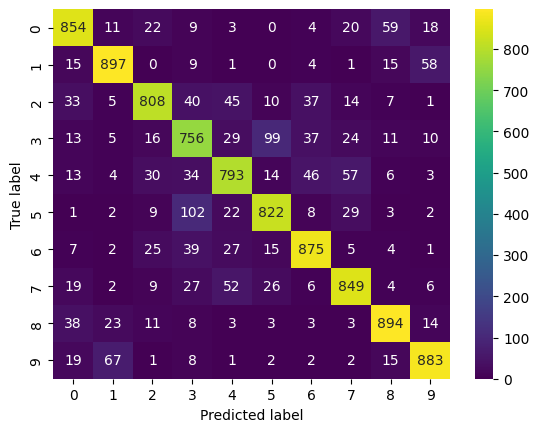

In [33]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [34]:
torch.save(model_resnet50.state_dict(), 'model_resnet50_linearTuned.pth')

# B) Knowledge distillation -> ResNet18 as Student and ResNet50(linear-tuned) as Teacher

In [35]:
weights = ResNet18_Weights.IMAGENET1K_V1
model_resnet18_distilled = resnet18(weights)

/home/user01/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [36]:
model_resnet18_distilled.fc = nn.Linear(512,10)
model_resnet18_distilled.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training model & Optimization & TensorBoard

In [37]:
import torch.nn.functional as F
class distillationLoss:
    def __init__(self, temperature=5, alpha=0.25):
        self.studentLoss = nn.CrossEntropyLoss()
        self.distillationLoss = nn.CrossEntropyLoss()
        self.temperature = temperature
        self.alpha = alpha

    def __call__(self, studentLogits, teacherLogits, groundTruth):
        distillationLoss = self.distillationLoss(F.log_softmax(studentLogits / self.temperature, dim=1),
                                                   F.softmax(teacherLogits / self.temperature, dim=1))
        
        studentLoss = self.studentLoss(F.softmax(studentLogits, dim=1), groundTruth)
        loss = (1 - self.alpha) * studentLoss + self.alpha * distillationLoss
        return loss

In [38]:
def train_Distillation_loop(dataloader, model_student, model_teacher, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    correct = 0
    model_student.train()
    model_teacher.eval()
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        Y = Y.to(device)
        studentLogits = model_student(X)
        teacherLogits = model_teacher(X)
        loss = loss_fn(studentLogits, teacherLogits, Y)
        avgLoss += loss.item()
        correct += (studentLogits.argmax(1) == Y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct /= size
    avgLoss /= size
    print(f"\n -Training Accuracy = {(100*correct):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return correct, avgLoss

In [39]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='knowledgeDistillation_Board')

epochs = 7
optimizer = torch.optim.Adam(model_resnet18_distilled.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_Distillation_loop(train_dataloader, model_resnet18_distilled, model_resnet50, distillationLoss(), optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_resnet18_distilled, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.303900  [    0/40000]
loss: 1.783099  [ 6400/40000]
loss: 1.758892  [12800/40000]
loss: 1.734267  [19200/40000]
loss: 1.742293  [25600/40000]
loss: 1.748001  [32000/40000]
loss: 1.721846  [38400/40000]

 -Training Accuracy = 86.9%, Avg loss = 0.027573 

 -Validation Error: Accuracy = 91.5%, Avg loss = 0.004499 

Epoch 2
-------------------------------
loss: 1.681113  [    0/40000]
loss: 1.704578  [ 6400/40000]
loss: 1.701204  [12800/40000]
loss: 1.693261  [19200/40000]
loss: 1.684399  [25600/40000]
loss: 1.709813  [32000/40000]
loss: 1.689537  [38400/40000]

 -Training Accuracy = 94.9%, Avg loss = 0.026484 

 -Validation Error: Accuracy = 93.6%, Avg loss = 0.003274 

Epoch 3
-------------------------------
loss: 1.680231  [    0/40000]
loss: 1.669269  [ 6400/40000]
loss: 1.701443  [12800/40000]
loss: 1.677289  [19200/40000]
loss: 1.689735  [25600/40000]
loss: 1.688634  [32000/40000]
loss: 1.687688  [38400/40000]

 -Training Accuracy = 97.

### Test and Result

* accuracy and loss for Test Dataset

In [40]:
test_loop(test_dataloader, model_resnet18_distilled, crossEntropy, 'Test');

 -Test Error: Accuracy = 92.9%, Avg loss = 0.004074 



In [41]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and losss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_resnet18_distilled(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [42]:
# classification report
print(classification_report(y_true=y_true, 
                            y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1000
           1       0.96      0.96      0.96      1000
           2       0.90      0.94      0.92      1000
           3       0.88      0.83      0.85      1000
           4       0.87      0.97      0.92      1000
           5       0.94      0.81      0.87      1000
           6       0.92      0.98      0.95      1000
           7       0.98      0.92      0.95      1000
           8       0.94      0.98      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



* confusion matrix

In [43]:
# Creating confusion matrix
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[942   5   8   3   2   0   0   2  34   4]
 [  4 956   1   0   0   0   2   0   9  28]
 [ 14   0 941   7  20   1  14   2   1   0]
 [  3   2  29 834  42  40  37   6   4   3]
 [  3   1   9   6 967   2   8   2   2   0]
 [  4   0  36  88  33 814  15   8   2   0]
 [  3   0   9   5   2   1 979   0   1   0]
 [ 10   1   6   8  41   8   4 922   0   0]
 [ 12   3   3   1   0   0   0   0 976   5]
 [ 12  23   0   1   0   0   0   0   6 958]]


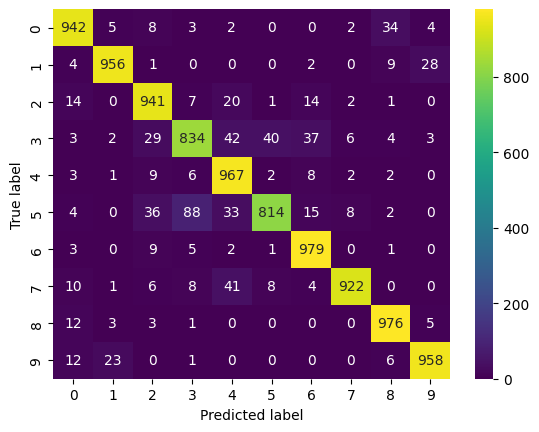

In [44]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [45]:
torch.save(model_resnet18_distilled.state_dict(), 'model_resnet18_distilled.pth')

# C) ResNet18 -> full Fine-tune

In [46]:
weights = ResNet18_Weights.IMAGENET1K_V1
model_resnet18 = resnet18(weights)

/home/user01/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [47]:
model_resnet18.fc  = nn.Linear(512,10)
model_resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training model & Optimization & TensorBoard

In [48]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet18_Board')

epochs = 7
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_resnet18, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_resnet18, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.482748  [    0/40000]
loss: 0.312475  [ 6400/40000]
loss: 0.412458  [12800/40000]
loss: 0.301495  [19200/40000]
loss: 0.361847  [25600/40000]
loss: 0.344441  [32000/40000]
loss: 0.295118  [38400/40000]

 -Training Accuracy = 87.3%, Avg loss = 0.005941 

 -Validation Error: Accuracy = 92.5%, Avg loss = 0.003379 

Epoch 2
-------------------------------
loss: 0.079196  [    0/40000]
loss: 0.041199  [ 6400/40000]
loss: 0.060077  [12800/40000]
loss: 0.059967  [19200/40000]
loss: 0.041139  [25600/40000]
loss: 0.223245  [32000/40000]
loss: 0.163036  [38400/40000]

 -Training Accuracy = 96.5%, Avg loss = 0.001709 

 -Validation Error: Accuracy = 93.0%, Avg loss = 0.003387 

Epoch 3
-------------------------------
loss: 0.058573  [    0/40000]
loss: 0.017799  [ 6400/40000]
loss: 0.015766  [12800/40000]
loss: 0.028446  [19200/40000]
loss: 0.014500  [25600/40000]
loss: 0.082659  [32000/40000]
loss: 0.015139  [38400/40000]

 -Training Accuracy = 98.

### Test and Result

* accuracy and loss for Test Dataset

In [49]:
test_loop(test_dataloader, model_resnet18, crossEntropy, 'Test');

 -Test Error: Accuracy = 92.3%, Avg loss = 0.004667 



In [50]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and losss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_resnet18(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [51]:
# classification report
print(classification_report(y_true=y_true, 
                            y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1000
           1       0.96      0.96      0.96      1000
           2       0.93      0.86      0.89      1000
           3       0.89      0.81      0.85      1000
           4       0.90      0.92      0.91      1000
           5       0.87      0.90      0.88      1000
           6       0.95      0.95      0.95      1000
           7       0.96      0.95      0.95      1000
           8       0.95      0.97      0.96      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



* confusion matrix

In [52]:
# Creating confusion matrix
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[960   3   2   3   0   0   0   0  27   5]
 [  5 962   0   1   0   0   0   0   5  27]
 [ 68   0 863  11  26  12  10   7   2   1]
 [ 18   1  22 813  29  81  23   8   2   3]
 [ 10   0  17   9 919  17   6  21   1   0]
 [  3   0   8  66  13 897   6   7   0   0]
 [  9   1  13   5  17   7 946   1   0   1]
 [  8   1   4   6  13  14   0 954   0   0]
 [ 13   5   3   0   0   1   0   0 971   7]
 [ 10  26   0   1   1   0   1   0  11 950]]


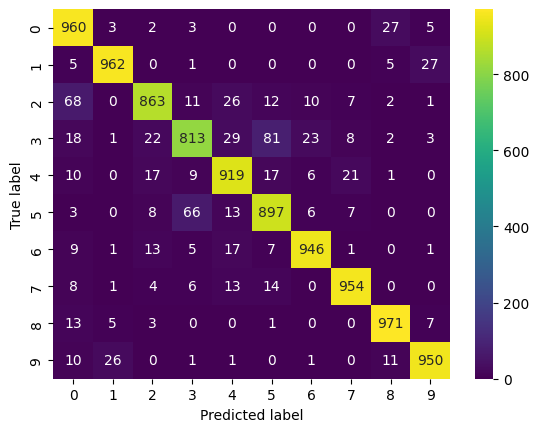

In [53]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [54]:
torch.save(model_resnet18.state_dict(), 'model_resnet18.pth')

### Comparing `B` and `C`:
> **Advantages of knowledge distillation**:
> * Less compute requirements and better performance than model trained without teacher model because the student model learns the characteristics of the teacher. 
> * Using a lighter model
> * Better accuracy than stand-alone model
> * Can be used even when there is lesser training data available for the student model

# D) Knowledge distillation -> ResNet18 as Student and ResNet50(full fine-tuned) as Teacher

## ResNet50 Fine-tune:

In [55]:
weights = ResNet50_Weights.IMAGENET1K_V2
model_resnet50_full = resnet50(weights)

/home/user01/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [56]:
model_resnet50_full.fc = nn.Linear(2048,10)
model_resnet50_full.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training model & Optimization & TensorBoard

In [57]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet50_Board')

epochs = 7
optimizer = torch.optim.Adam(model_resnet50_full.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model_resnet50_full, crossEntropy, optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_resnet50_full, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.360559  [    0/40000]
loss: 0.337418  [ 6400/40000]
loss: 0.465908  [12800/40000]
loss: 0.318743  [19200/40000]
loss: 0.299297  [25600/40000]
loss: 0.209263  [32000/40000]
loss: 0.048351  [38400/40000]

 -Training Accuracy = 90.2%, Avg loss = 0.005112 

 -Validation Error: Accuracy = 95.5%, Avg loss = 0.002154 

Epoch 2
-------------------------------
loss: 0.042656  [    0/40000]
loss: 0.135490  [ 6400/40000]
loss: 0.147229  [12800/40000]
loss: 0.043107  [19200/40000]
loss: 0.022091  [25600/40000]
loss: 0.174488  [32000/40000]
loss: 0.122460  [38400/40000]

 -Training Accuracy = 97.6%, Avg loss = 0.001139 

 -Validation Error: Accuracy = 95.8%, Avg loss = 0.002009 

Epoch 3
-------------------------------
loss: 0.078620  [    0/40000]
loss: 0.007630  [ 6400/40000]
loss: 0.018753  [12800/40000]
loss: 0.091526  [19200/40000]
loss: 0.006121  [25600/40000]
loss: 0.094515  [32000/40000]
loss: 0.030317  [38400/40000]

 -Training Accuracy = 98.

## ResNet18 : Knowledge distillation

In [58]:
weights = ResNet18_Weights.IMAGENET1K_V1
model_resnet18_distilled_full = resnet18(weights)

In [59]:
model_resnet18_distilled_full.fc = nn.Linear(512,10)
model_resnet18_distilled_full.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training model & Optimization & TensorBoard

In [60]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='knowledgeDistillation_full_Board')

epochs = 7
optimizer = torch.optim.Adam(model_resnet18_distilled_full.parameters(), lr=0.0001)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_Distillation_loop(train_dataloader, model_resnet18_distilled_full, model_resnet50_full, distillationLoss(), optimizer)
    writer.add_scalar('Accuracy/train', trainAcc, e)
    writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model_resnet18_distilled_full, crossEntropy, 'Validation')
    writer.add_scalar('Accuracy/validation', valAcc, e)
    writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.284303  [    0/40000]
loss: 1.623864  [ 6400/40000]
loss: 1.606618  [12800/40000]
loss: 1.564070  [19200/40000]
loss: 1.607589  [25600/40000]
loss: 1.555243  [32000/40000]
loss: 1.576042  [38400/40000]

 -Training Accuracy = 86.3%, Avg loss = 0.025580 

 -Validation Error: Accuracy = 92.2%, Avg loss = 0.004912 

Epoch 2
-------------------------------
loss: 1.551299  [    0/40000]
loss: 1.568053  [ 6400/40000]
loss: 1.523078  [12800/40000]
loss: 1.564402  [19200/40000]
loss: 1.548536  [25600/40000]
loss: 1.554309  [32000/40000]
loss: 1.565473  [38400/40000]

 -Training Accuracy = 94.3%, Avg loss = 0.024255 

 -Validation Error: Accuracy = 92.6%, Avg loss = 0.004684 

Epoch 3
-------------------------------
loss: 1.563205  [    0/40000]
loss: 1.531483  [ 6400/40000]
loss: 1.544432  [12800/40000]
loss: 1.568351  [19200/40000]
loss: 1.528682  [25600/40000]
loss: 1.492010  [32000/40000]
loss: 1.515993  [38400/40000]

 -Training Accuracy = 96.

## Test and Result

* accuracy and loss for Test Dataset

In [61]:
test_loop(test_dataloader, model_resnet18_distilled_full, crossEntropy, 'Test');

 -Test Error: Accuracy = 93.2%, Avg loss = 0.004392 



In [62]:
y_pred = []
y_true = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Compute prediction and losss
        X = X.to(device)
        Y = Y.to(device)
        pred = model_resnet50_full(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_true.extend(Y.cpu().numpy())

* classification report (precision, recall, accuracy)

In [63]:
# classification report
print(classification_report(y_true=y_true, 
                            y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.94      0.99      0.96      1000
           2       0.96      0.94      0.95      1000
           3       0.89      0.93      0.91      1000
           4       0.94      0.95      0.95      1000
           5       0.95      0.89      0.92      1000
           6       0.95      0.98      0.97      1000
           7       0.98      0.97      0.97      1000
           8       0.99      0.96      0.98      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



* confusion matrix

In [64]:
# Creating confusion matrix
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

[[977   3   8   1   0   0   2   2   6   1]
 [  1 989   0   0   0   0   0   0   1   9]
 [  8   0 944  19  11  10   5   2   1   0]
 [  4   2   6 925  13  27  18   2   1   2]
 [  0   0   8   5 954   4  16  12   1   0]
 [  0   2   2  78  19 887   5   6   1   0]
 [  1   1   7   5   0   0 985   0   0   1]
 [  0   0   3   5  20   3   2 967   0   0]
 [ 14  13   2   0   1   0   1   0 962   7]
 [  7  43   0   1   1   1   0   0   0 947]]


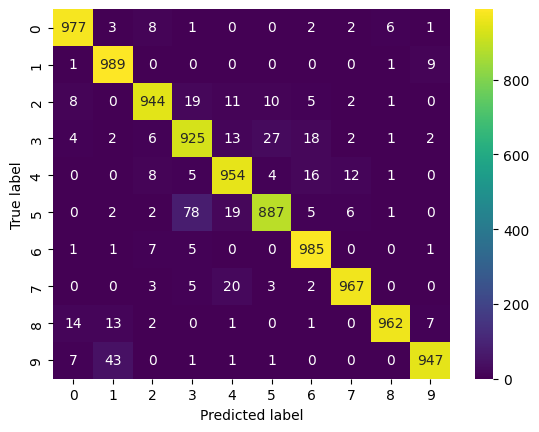

In [65]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [66]:
torch.save(model_resnet18_distilled_full.state_dict(), 'model_resnet18_distilled_full.pth')

## Comparing `B` and `D`:
> The Resnet50 network was fine-tuned and used as a teacher in this section. The accuracy of Resnet50 in full fine-tuning is higher than linear tuning (about 95% compared to 80%). After that, we trained Resnet18 using the knowledge-distillation method with Resnet50 as a teacher. As we can see, the student learned more in part B because the teacher had more information.